# Setup and imports

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tifffile
from pathlib import Path
from tqdm import tqdm
import czifile
from csbdeep.utils import normalize
from utils import read_czi_image, fix_overlap

# Input image and ground truth label loaders 

In [2]:
# Define the directories containing your training/validation images and annotated ground truth pairs
img_directory = Path("./train_validation_data/train_data")
label_directory = Path("./train_validation_data/ground_truth_labels")

In [3]:
# Create a list containing all file paths to both .czi input images and .tiff ground truth labels
f_masks = sorted(label_directory.glob("*.tiff"))
f_images = sorted(img_directory.glob("*.czi"))

print(f'Found {len(f_images)} images and {len(f_masks)} annotations')

Found 6 images and 18 annotations


In [4]:
# Read each .czi stack, reshape it into channels-last format and apply percentile-based normalization

# Initialize an empty list to hold the normalized images
normalized_images = []

# Iterate over each .czi stack contained in f_images
for filepath in tqdm(f_images):

    # Read the image from file and reshape it into channels-last format
    image = read_czi_image(filepath)

    # Normalize the read image along axes 0 and 1 (X and Y)
    normalized_image = normalize(image, axis=(0,1))

    # Append the normalize image to the list
    normalized_images.append(normalized_image)

# Convert the list into a tuple (this is intended to be an immutable fixed set of images)
imgs = tuple(normalized_images)

# A more concise way to perform the same process using list comprehensions
# imgs = tuple(normalize(read_czi_image(filepath), axis=(0,1)) for filepath in tqdm(f_images))

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


In [5]:
# Ground truth label loader (ome.tiff files)
raw_masks = tuple(tifffile.imread(filepath) for filepath in tqdm(f_masks))

100%|██████████| 18/18 [00:00<00:00, 25.75it/s]


# Removing overlapping pixels in between class annotations

In [6]:
masks, bh_shared, bt_shared, ht_shared = fix_overlap(raw_masks, f_masks)
del raw_masks # Remove raw_masks variable to free up memory    


Fixing overlap results: 

1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (6561, 7479, 3) 


Fixing overlap results: 

1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (9315, 9288, 3) 


Fixing overlap results: 

1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (8424, 9342, 3) 


Fixing overlap results: 

1837I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (8424, 8397, 3) 


Fixing overlap results: 

1849I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share 

In [ ]:
# Checking how many pixels overlaped in between classes (bh_shared, bt_shared, ht_shared)
for i, array in enumerate(ht_shared):
    print(f"Array {i}")
    unique_values, value_counts = np.unique(array, return_counts=True)
    # Print the unique values and their counts
    for value, count in zip(unique_values, value_counts):
        print(f"Value: {value}, Count: {count}")

# Visualize annotations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


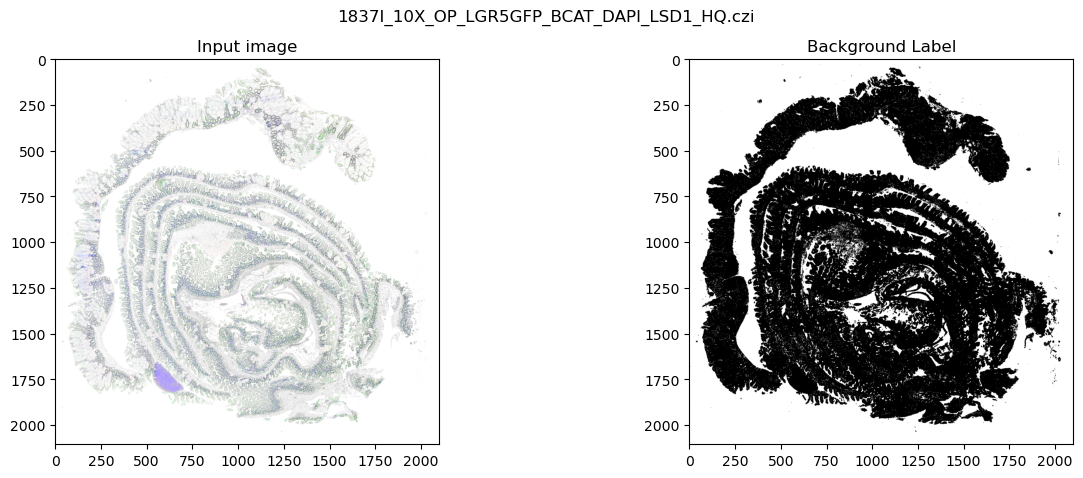

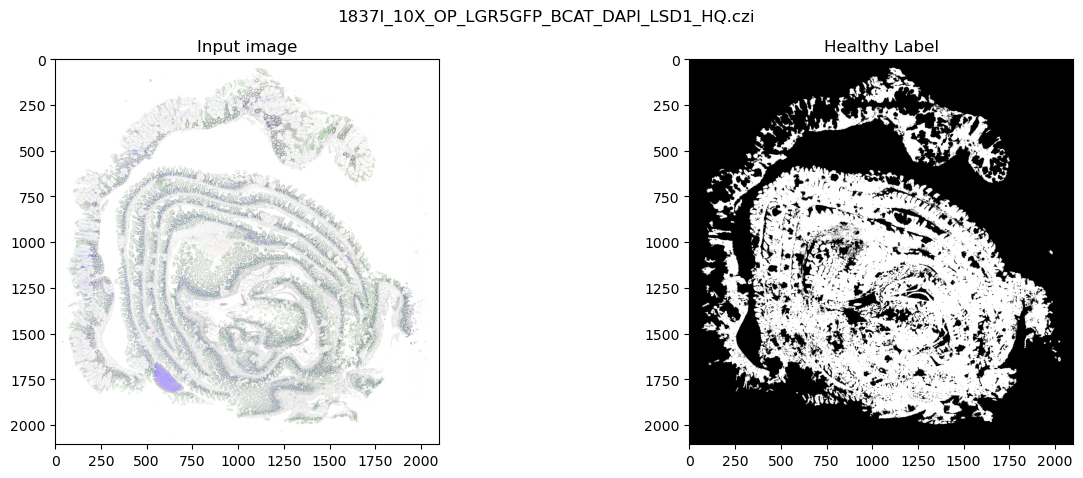

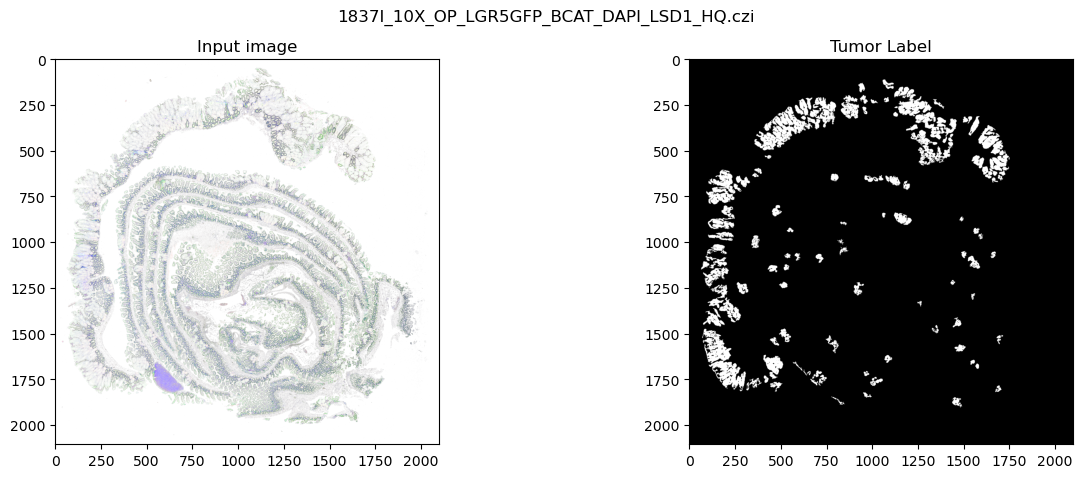

In [13]:
# Plot an example image and all of its segmentation masks
i = 3 #Define the position of the sample in the array

graph_title = ["Background", "Healthy", "Tumor"]

for mask_nr in range(3):
    fig, (a0,a1) = plt.subplots(1,2,figsize=(15,5))
    a0.imshow(imgs[i][::4,::4]); #plot every 4th pixel (subsampling)
    a0.set_title('Input image')
    a1.imshow(masks[i][::4,::4,mask_nr], cmap='gray'); #plot every 4th pixel (subsampling)                    
    a1.set_title(f"{graph_title[mask_nr]} Label")
    fig.suptitle(f_images[i].name)
    # plt.savefig(fname=f"prediction_tiffs/{f_images[i].name}.{graph_title[mask_nr]}.png", dpi=300, format='png')
    None;

# Train and validation dataset definition

In [30]:
# Using list slicing to leave 2 validation images one with and one without tumors (at index 3 and 5)
# By specifying dtype=object np allows for the creation of an ndarray that can store arrays with different shapes
imgs_array = np.asarray(imgs, dtype=object)
masks_array = np.asarray(masks, dtype=object)
train_index = [0, 1, 2, 4]
val_index = [3, 5]

X = tuple(imgs_array[train_index]) # Training inputs (features)
Y = list(masks_array[train_index]) # Training labels (target)

Xv = tuple(imgs_array[val_index]) # Validation inputs (features)
Yv = list(masks_array[val_index]) # Validation labels (target)

print(f"X: {len(X)}, Y: {len(Y)}, Xv: {len(Xv)}, Yv: {len(Yv)}")

X: 4, Y: 4, Xv: 2, Yv: 2


# Model (U-net)

In [31]:
import model as M

In [32]:
n_dim=2

conf = M.UNetConfig(n_dim=n_dim,
                  n_channel_in = 4,
                  n_channel_out = 3,
                  patch_size=(512,512),
                  train_batch_size=4,
                  train_class_weight = (1,1,1))

In [33]:
vars(conf)

{'n_dim': 2,
 'axes': 'XYC',
 'n_channel_in': 4,
 'n_channel_out': 3,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'softmax',
 'unet_input_shape': (None, None, 4),
 'train_loss': 'categorical_crossentropy',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0},
 'train_class_weight': (1, 1, 1),
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'patch_size': (512, 512)}

In [41]:
model = M.UNet(conf, 'model1_epoch100', basedir='models')

In [42]:
model.train(X, Y, Xv, Yv, epochs=100, steps_per_epoch=16)

Epoch 1/100
16/16 [==============================] - 2s 87ms/step - loss: 0.9518 - metric_precision: 0.5121 - metric_recall: 0.1461 - metric_f1: 0.2107 - val_loss: 0.8287 - val_metric_precision: 0.8229 - val_metric_recall: 0.2301 - val_metric_f1: 0.3597 - lr: 4.0000e-04
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6769 - metric_precision: 0.7347 - metric_recall: 0.4863 - metric_f1: 0.5412 - val_loss: 0.1512 - val_metric_precision: 0.9216 - val_metric_recall: 0.9499 - val_metric_f1: 0.9355 - lr: 4.0000e-04
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.2563 - metric_precision: 0.8479 - metric_recall: 0.8825 - metric_f1: 0.8648 - val_loss: 0.1472 - val_metric_precision: 0.9199 - val_metric_recall: 0.9420 - val_metric_f1: 0.9308 - lr: 4.0000e-04
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.1922 - metric_precision: 0.8985 - metric_recall: 0.9055 - metric_f1: 0.9018 - val_loss: 0.0921 - val_metric_pre

# Apply the model on a test image

In [36]:
test_img_directory = Path("Zeiss_Raw_Test")
f_test_images = sorted(test_img_directory.glob("*.czi"))
print(f'found {len(f_test_images)} test images')

test_imgs = tuple(normalize(read_czi_image(f), axis=(0,1)) for f in tqdm(f_test_images))

'ls' is not recognized as an internal or external command,
operable program or batch file.


found 7 test images


100%|██████████| 7/7 [00:25<00:00,  3.71s/it]


In [43]:
model

UNet(model1_epoch100): XYC → XYC
├─ Directory: C:\Users\adiez_cmic\github_repos\UNet_SemSeg_healthy_tumor_SRs\models\model1_epoch100
└─ UNetConfig(n_dim=2, axes='XYC', n_channel_in=4, n_channel_out=3, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=False, unet_n_depth=2, unet_kern_size=3, unet_n_first=32, unet_last_activation='softmax', unet_input_shape=(None, None, 4), train_loss='categorical_crossentropy', train_epochs=100, train_steps_per_epoch=400, train_learning_rate=0.0004, train_batch_size=4, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0, 'verbose': True}, train_class_weight=(1, 1, 1), unet_batch_norm=False, unet_dropout=0.0, patch_size=(512, 512))

In [44]:
predictions = []
for img in test_imgs:
    prediction = model.predict(img, axes='XYC', n_tiles=(8,8,1))
    predictions.append(prediction)
    print(prediction.shape)

100%|██████████| 64/64 [00:03<00:00, 17.38it/s]


(7479, 7506, 3)


100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


(7479, 7479, 3)


100%|██████████| 64/64 [00:03<00:00, 18.63it/s]


(5670, 8397, 3)


100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


(7506, 7506, 3)


100%|██████████| 64/64 [00:02<00:00, 21.78it/s]


(6561, 5616, 3)


100%|██████████| 64/64 [00:03<00:00, 17.79it/s]


(6588, 7479, 3)


100%|██████████| 64/64 [00:03<00:00, 19.78it/s]

(6561, 6561, 3)


In [45]:
len(predictions)

7

0it [00:00, ?it/s]

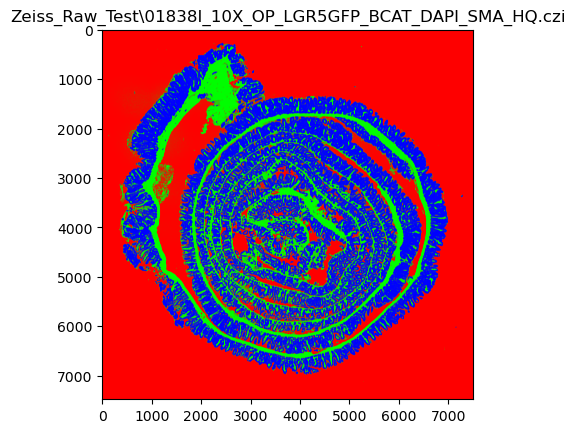

1it [00:02,  2.36s/it]

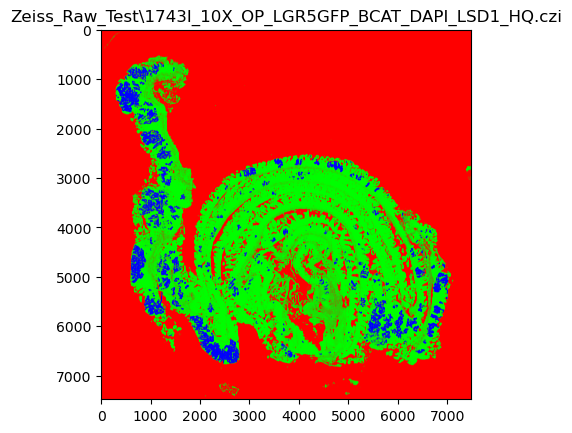

2it [00:04,  2.39s/it]

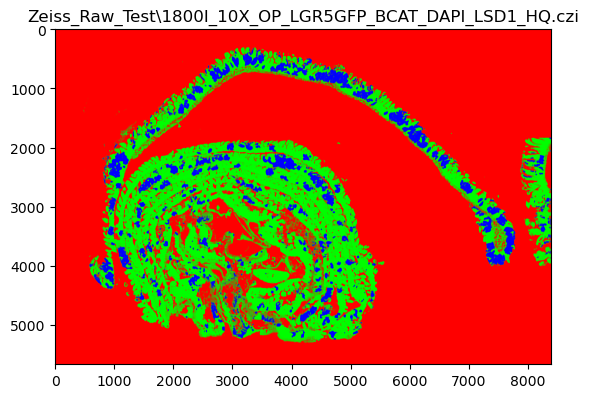

3it [00:06,  2.32s/it]

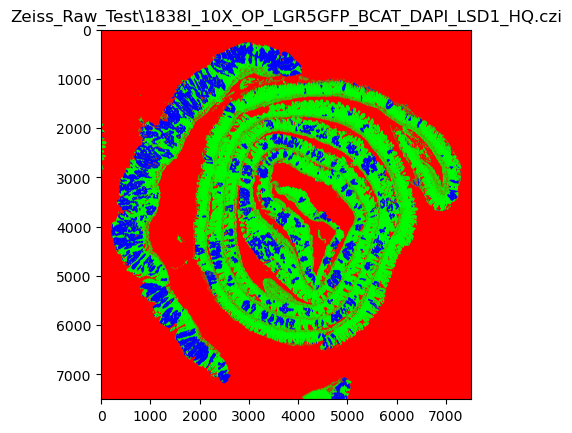

4it [00:09,  2.34s/it]

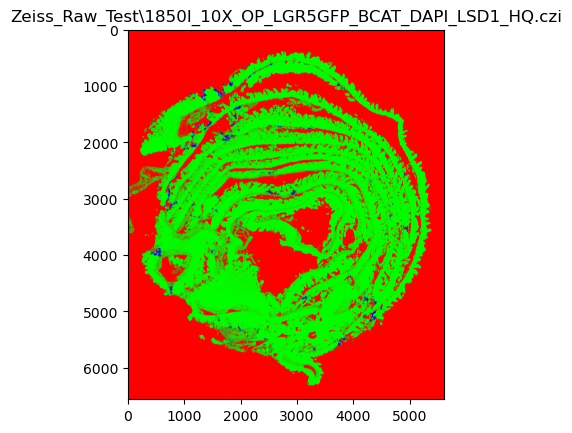

5it [00:11,  2.11s/it]

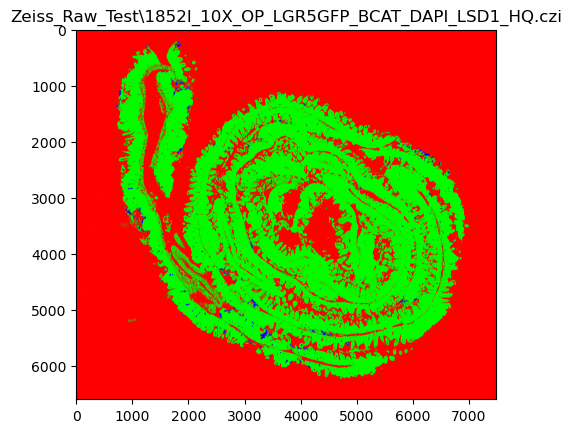

6it [00:13,  2.17s/it]

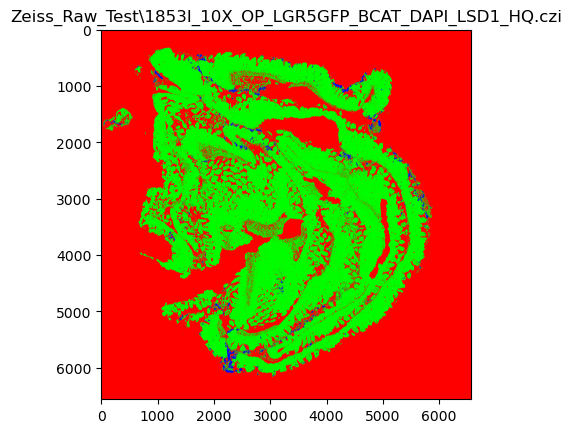

7it [00:15,  2.20s/it]


In [46]:
for i, img in tqdm(enumerate(predictions)):
    plt.imshow(img)
    plt.title(f_test_images[i])
    plt.show()